In [2]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

from osgeo import gdal

from matplotlib import ticker
from matplotlib.patches import Ellipse
from matplotlib.offsetbox import AnchoredText

from netCDF4 import Dataset

%matplotlib inline
plt.rcParams['figure.dpi'] = 300

import multiprocessing as mp
mp.cpu_count()
import multiprocessing
from itertools import product
from sklearn.linear_model import LinearRegression

In [3]:
img = gdal.Open('/home/denis/L_C_alignment/aligned/north_greenland/019/UPS_XX_S1B_EW_GRDM_1SDH_20191127T190340_20191127T190444_019117_02414A_A64B.tiff').ReadAsArray()[0,:,:]

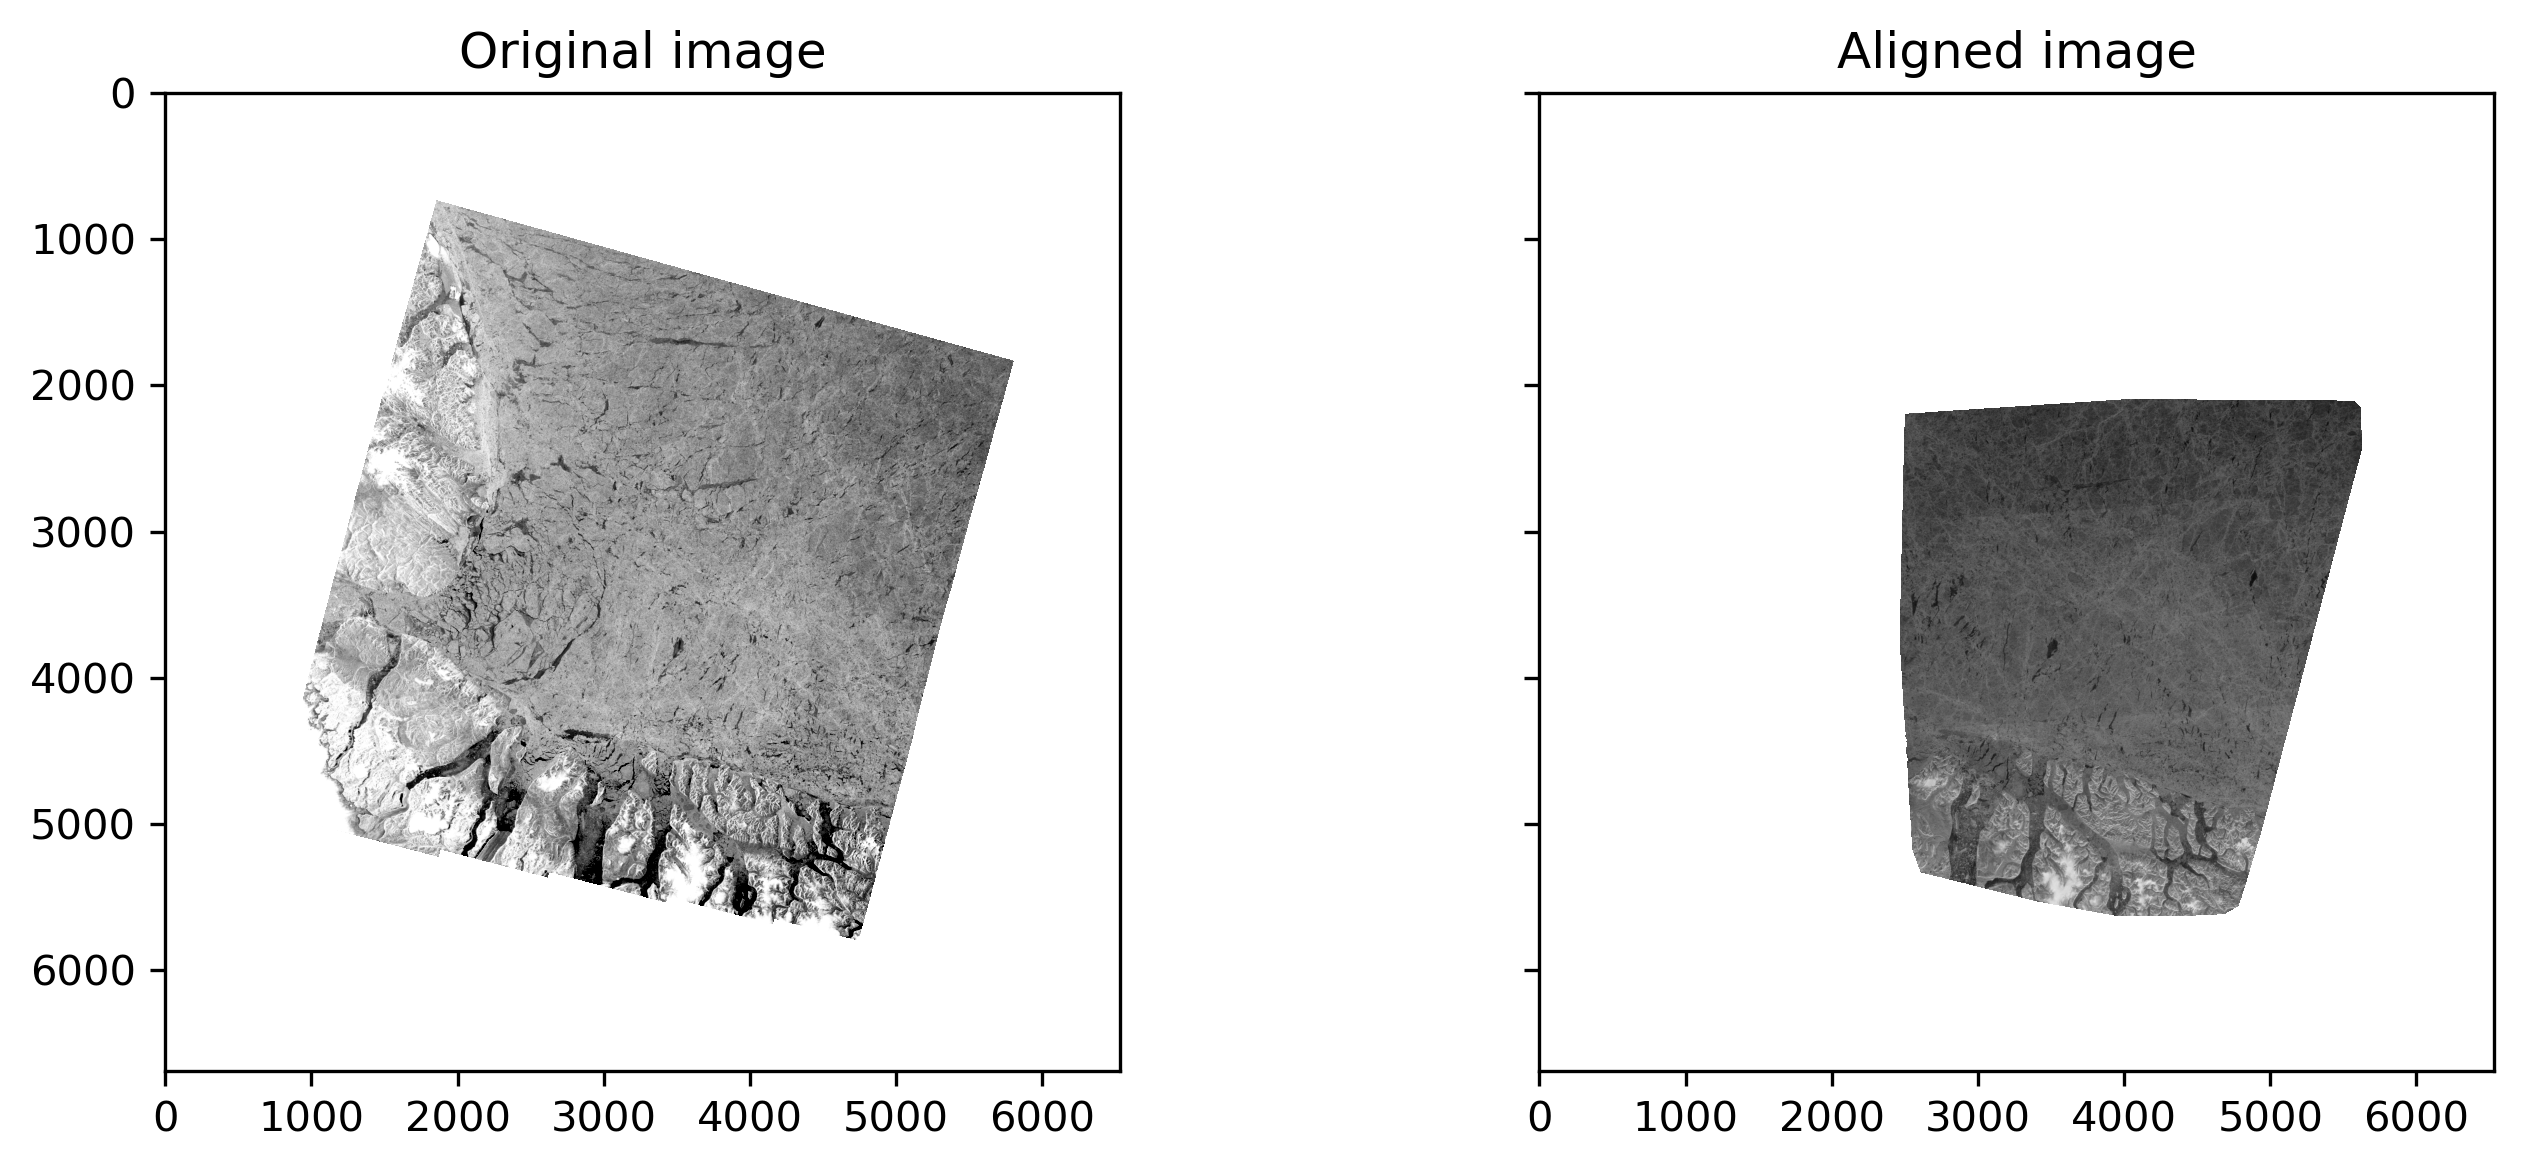

In [4]:
# Constants

downsample_factor = 1

f1 = '/home/denis/L_C_alignment/aligned/north_greenland/019/UPS_XX_S1B_EW_GRDM_1SDH_20191127T190340_20191127T190444_019117_02414A_A64B.tiff'
f2 = '/home/denis/L_C_alignment/aligned/north_greenland/019/Aligned_UPS_XX_ALOS2_XX_XXXX_XXXX_20191125T174023_20191125T174115_0000326230_001001_ALOS2297431900-191125.tiff'

w, h = gdal.Open(f1).ReadAsArray()[0,:,:].shape

r1, r2, c1, c2 = 0, w, 0, h

# Window size for alignemt quality assessment
ws = 15

vmin = -20
vmax = -5

img = gdal.Open(f1).ReadAsArray()[0,r1:r2,c1:c2]
img_aligned = gdal.Open(f2).ReadAsArray()[0,r1:r2,c1:c2]
rows, cols = img.shape

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4),
                         sharex=True, sharey=True)
ax = axes.ravel()

mse_none = mean_squared_error(img, img)
ssim_none = ssim(img, img, data_range=img.max() - img.min())

mse_aligned = mean_squared_error(img, img_aligned)
ssim_aligned = ssim(img, img_aligned,
                  data_range=img_aligned.max() - img_aligned.min())

ax[0].imshow(img, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
ax[0].set_title('Original image')

ax[1].imshow(img_aligned, cmap=plt.cm.gray)#, vmin=vmin, vmax=vmax)
ax[1].set_title('Aligned image')

plt.tight_layout()
plt.show()

In [15]:
#####################################
# Calculate SSIM and MSE
#####################################

def calc_smmi(rr1, rr2, cc1, cc2):
    '''Calculate SSIM metric for an image patch '''
    q_ssim = ssim(img[rr1:rr2, cc1:cc2], img_aligned[rr1:rr2, cc1:cc2],
                  data_range=img_aligned[rr1:rr2, cc1:cc2].max() - img_aligned[rr1:rr2, cc1:cc2].min())
    return q_ssim

def calc_mse(rr1, rr2, cc1, cc2):
    '''Calculate MSE metric for an image patch '''
    q_ssim = ssim_aligned = mean_squared_error(img[rr1:rr2, cc1:cc2], img_aligned[rr1:rr2, cc1:cc2])
    return q_ssim

if __name__ == '__main__':
    coords = []
      
    for i,r in enumerate(range(0,rows,downsample_factor)):
        for j,c in enumerate(range(0,cols,downsample_factor)):

            #print(f'i,j: {i:d},{j:d} of {round(rows/downsample_factor)},{round(cols/downsample_factor)}')

            rr1 = max(0, r-ws)
            rr2 = min(rows, r+ws)

            cc1 = max(0, c-ws)
            cc2 = min(cols, c+ws)

            icoord = tuple([rr1,rr2,cc1,cc2])

            coords.append(icoord)
    
    print('Start processing...')
    with multiprocessing.Pool(processes=20) as pool:
        smmi = pool.starmap(calc_smmi, coords)
    print('Done.')
        
    print('Start processing...')
    with multiprocessing.Pool(processes=20) as pool:
        mse = pool.starmap(calc_mse, coords)
    print('Done.')
    
    # Convert to 2-D matriсes
    m_smmi = np.array(smmi).reshape(rows, cols)
    m_mse = np.array(mse).reshape(rows, cols)

Start processing...
Done.
Start processing...
Done.


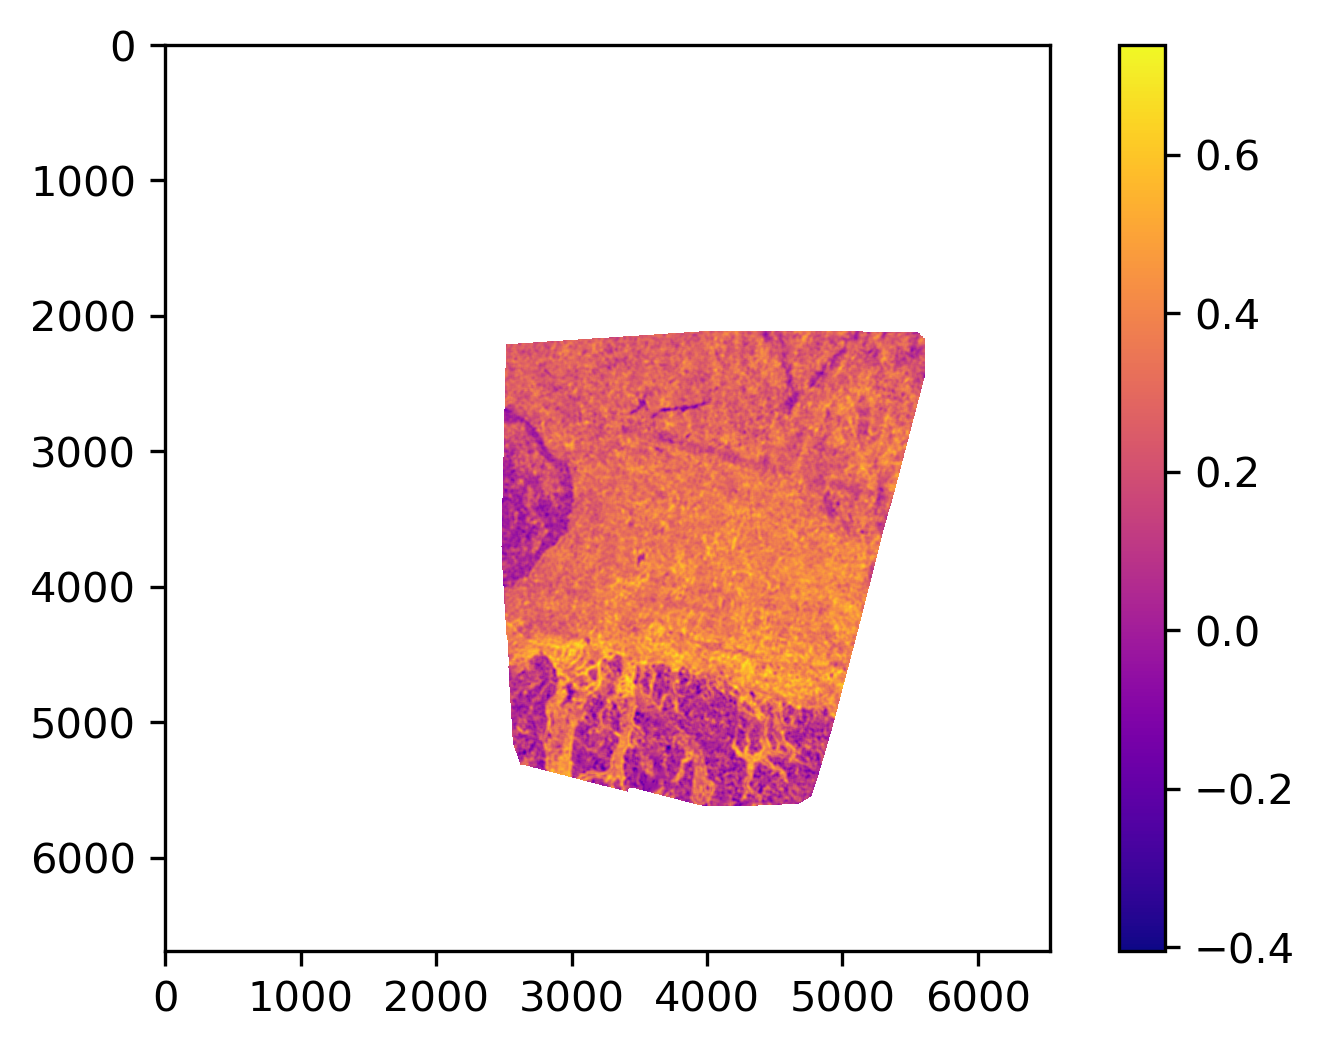

In [616]:
plt.imshow(m_smmi, cmap='plasma')
plt.colorbar()

In [617]:
np.nanmean(m_smmi), np.nanmean(m_mse)

(0.28052309749942694, 52.0150724248035)

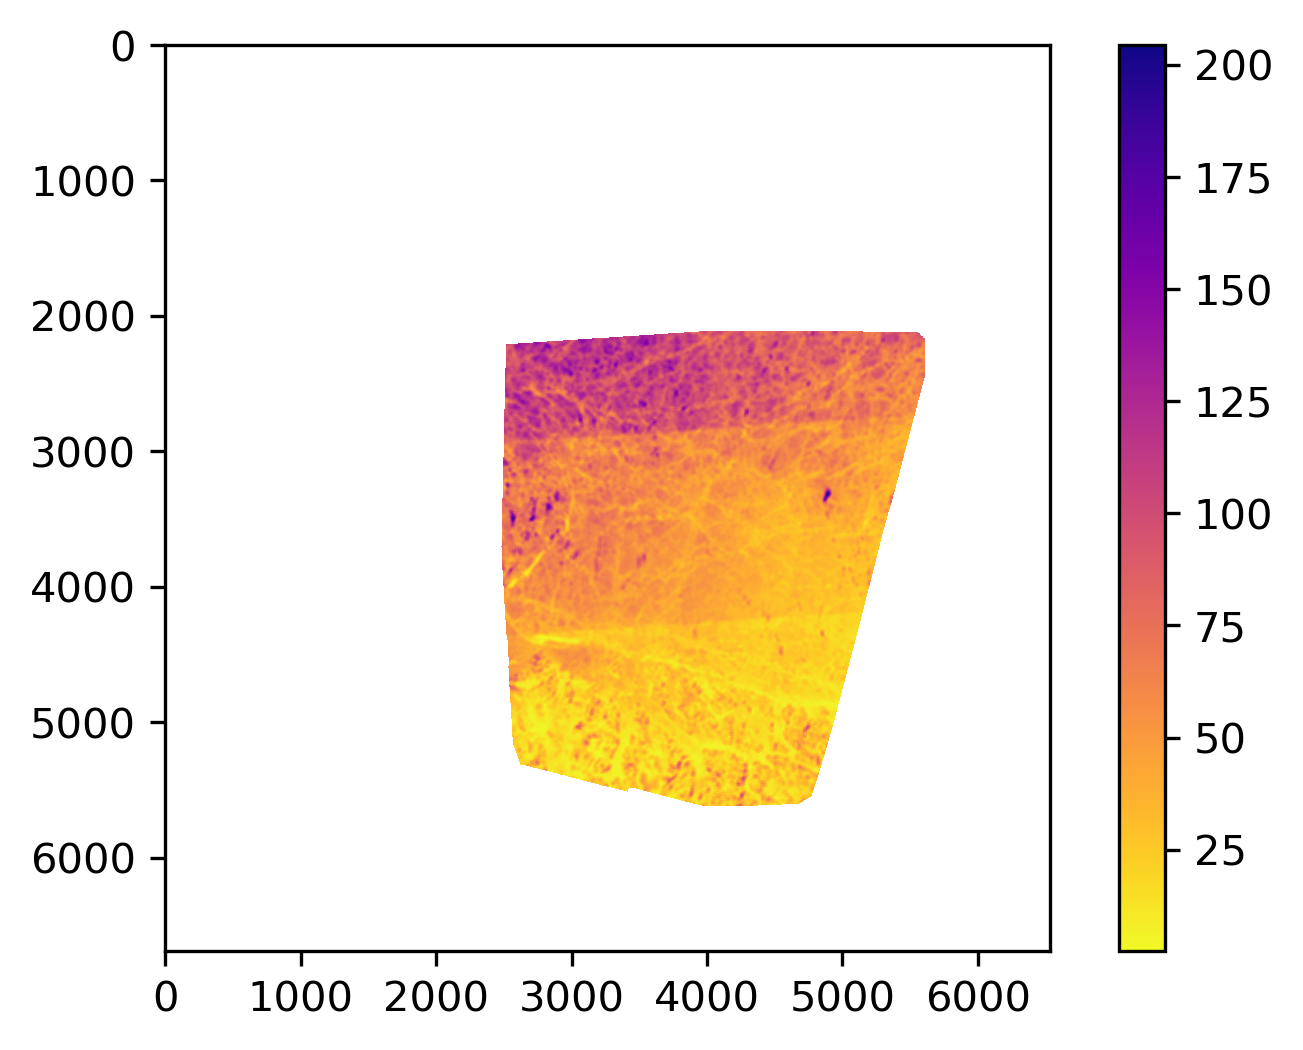

In [618]:
plt.imshow(m_mse, cmap='plasma_r')
plt.colorbar()

In [621]:
# Deformation data
f_defo = '/data/rrs/seaice/esa_rosel/L_C_pairs/north_greenland/wb_dd/drift_results/019/output/Chalmers_Ice_Defo_20191125T1740_20191127T1903.nc'
t_def = nc.Dataset(f_defo)['Total_deformation'][:]
div = nc.Dataset(f_defo)['Divergence'][:]
shear = nc.Dataset(f_defo)['Shear'][:]

/home/denis/.conda/envs/test2/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
/home/denis/.conda/envs/test2/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/home/denis/.conda/envs/test2/lib/python3.7/site-packages/ipykernel_launcher.py:7: Depr

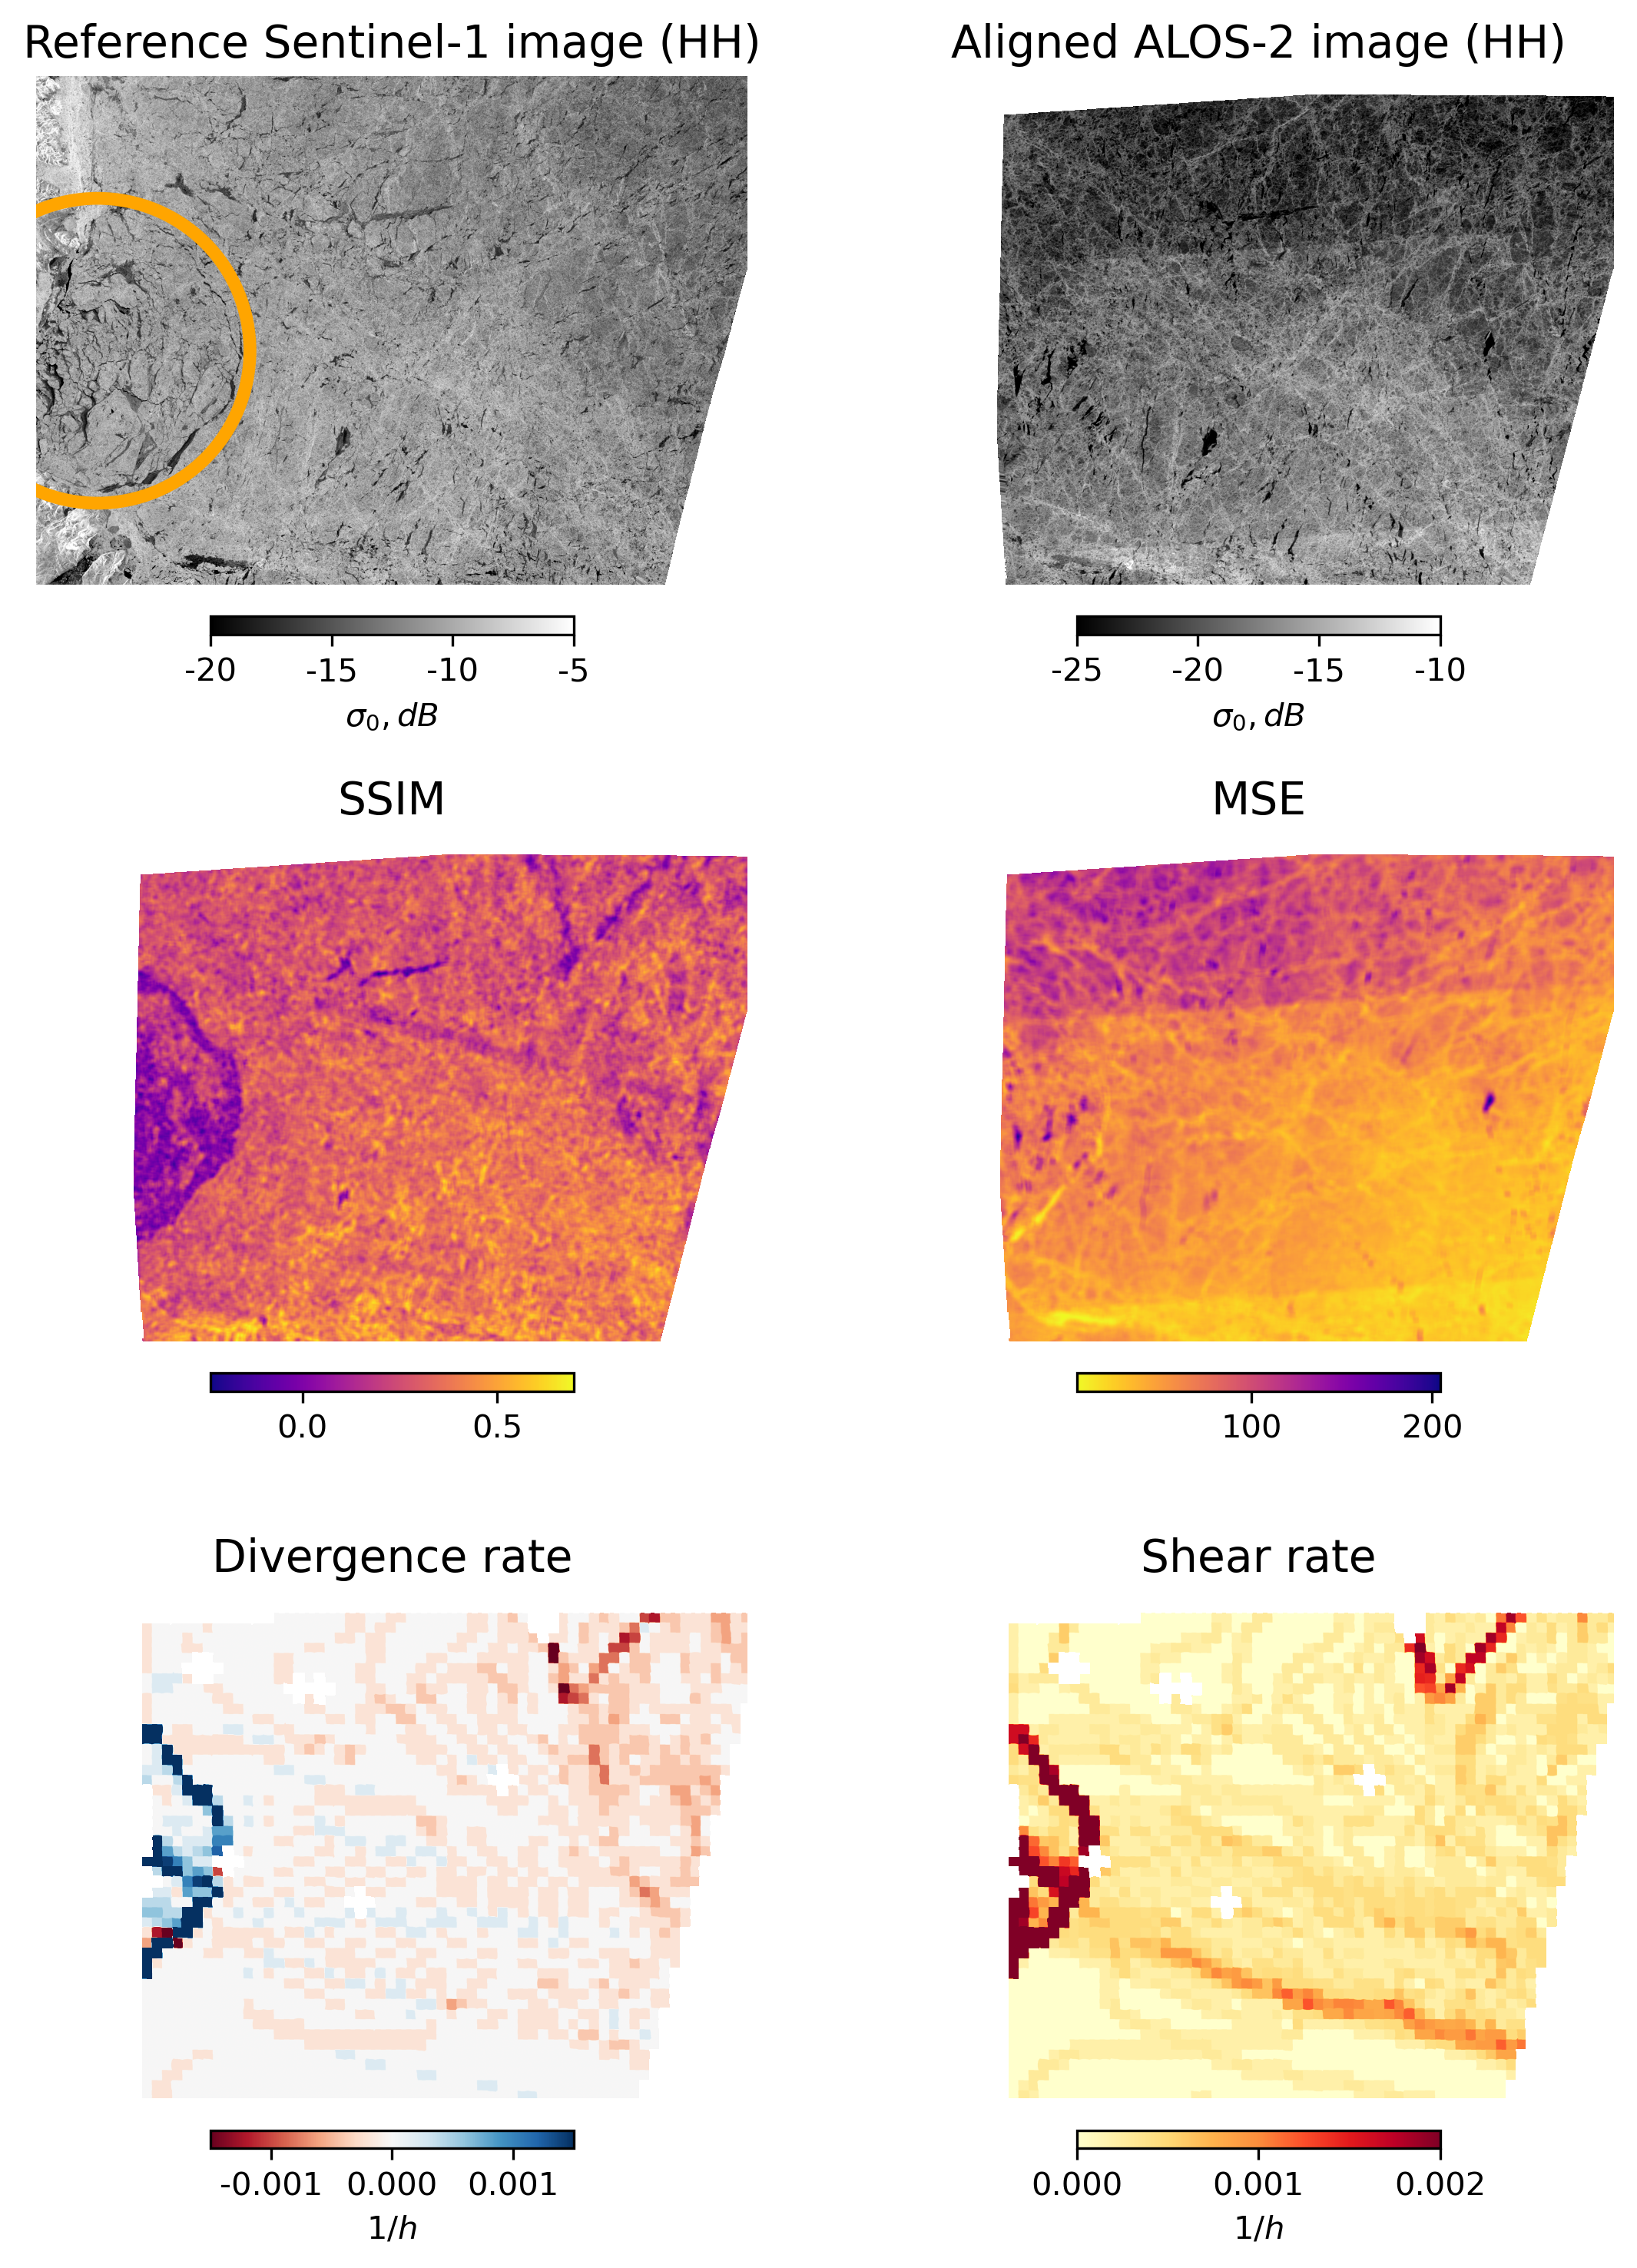

In [680]:
def myfmt(x, pos):
    return '{0:.3f}'.format(x)

def myfmt2(x, pos):
    return '{0:.0f}'.format(x)

def myfmt1(x, pos):
    return '{0:.1f}'.format(x)

# Constants
downsample_factor = 1
font_size = 14
shrink = 0.4

# Zoom window
# 2000, 5500, 2000, 5500
rr1, rr2, cc1, cc2  = 2000, 4500, 2000, 5500

vmin = -20
vmax = -5

img = gdal.Open(f1).ReadAsArray()[0,r1:r2,c1:c2]
img_aligned = gdal.Open(f2).ReadAsArray()[0,r1:r2,c1:c2]
rows, cols = img.shape

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8, 10),
                         sharex=True, sharey=True)

mse_none = np.nanmean(m_mse)
ssim_none = np.nanmean(m_smmi)

im_ref = ax[0,0].imshow(img[rr1:rr2,cc1:cc2], cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
ax[0,0].set_xlabel(f'MSE: {mse_none:.2f}, SSIM: {ssim_none:.2f}')
ax[0,0].set_title('Reference Sentinel-1 image (HH)', size=font_size)
fig.colorbar(im_ref, ax=ax[0,0], location='bottom', label='$\sigma_0, dB$',
             shrink=shrink,  pad=0.05, format=ticker.FuncFormatter(myfmt2))

# draw the ellipse over new ridge
ell = Ellipse(xy=[300,1350], width=1500, height=1500, angle=0,
              edgecolor='orange', lw=4, facecolor='none')

ax[0,0].add_artist(ell)

im_trg = ax[0,1].imshow(img_aligned[rr1:rr2,cc1:cc2], vmin=-25, vmax=-10, cmap=plt.cm.gray) #, vmin=vmin, vmax=vmax)
#ax[1].set_xlabel(f'MSE: {mse_aligned:.2f}, SSIM: {ssim_aligned:.2f}')
ax[0,1].set_title('Aligned ALOS-2 image (HH)', size=font_size)
fig.colorbar(im_trg, ax=ax[0,1], location='bottom', label='$\sigma_0, dB$',
             shrink=shrink,  pad=0.05, format=ticker.FuncFormatter(myfmt2))

im_smmi = ax[1,0].imshow(m_smmi[rr1:rr2,cc1:cc2], cmap='plasma')
ax[1,0].set_xlabel(f'')
ax[1,0].set_title('SSIM', size=font_size)
fig.colorbar(im_smmi, ax=ax[1,0], location='bottom', label='',
             shrink=shrink,  pad=0.05, format=ticker.FuncFormatter(myfmt1))

im_mse = ax[1,1].imshow(m_mse[rr1:rr2,cc1:cc2], cmap='plasma_r')
ax[1,1].set_xlabel(f'')
ax[1,1].set_title('MSE', size=font_size)
fig.colorbar(im_mse, ax=ax[1,1], location='bottom', label='',
             shrink=shrink,  pad=0.05, format=ticker.FuncFormatter(myfmt2))

im_div = ax[2,0].imshow(div_int[rr1:rr2,cc1:cc2], cmap='RdBu', vmin=-0.0015, vmax=0.0015)
ax[2,0].set_xlabel(f'')
ax[2,0].set_title('Divergence rate', size=font_size)
fig.colorbar(im_div, ax=ax[2,0], location='bottom', label='$1/h$', shrink=shrink,
             pad=0.05, format=ticker.FuncFormatter(myfmt))

im_shear = ax[2,1].imshow(shear_int[rr1:rr2,cc1:cc2], cmap='YlOrRd', vmin=0., vmax=0.002)
ax[2,1].set_xlabel(f'')
ax[2,1].set_title('Shear rate', size=font_size)
fig.colorbar(im_shear, ax=ax[2,1], location='bottom', label='$1/h$', shrink=shrink,
             pad=0.05, format=ticker.FuncFormatter(myfmt))

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[1,0].axis('off')
ax[1,1].axis('off')
ax[2,0].axis('off')
ax[2,1].axis('off')

plt.tight_layout()

plt.savefig('/data/rrs/seaice/esa_rosel/report_paper/figures/ex_ssim_defo.png', bbox_inches='tight', dpi=300)

In [622]:
t_def.shape, m_smmi.shape

((71, 63), (6689, 6530))

In [10]:
#############################################
# Regression between divergence and SSIM
#############################################

# Open and prepare deformation data
f_defo = '/data/rrs/seaice/esa_rosel/L_C_pairs/north_greenland/wb_dd/drift_results/019/output/TOTAL_DEF_20191125T1740_20191127T1903.tiff'

# Reproject defo file
reader = dataReader()

# Interpolate divergence
r = Resampler(f_defo, f1)
tdef_int = r.resample(r.f_source['lons'], r.f_source['lats'],
                       r.f_target['lons'], r.f_target['lats'], r.f_source['data']['s0'], method='nearest')


Resampling source file: /data/rrs/seaice/esa_rosel/L_C_pairs/north_greenland/wb_dd/drift_results/019/output/TOTAL_DEF_20191125T1740_20191127T1903.tiff ...
Done.


Resampling target file: /home/denis/L_C_alignment/aligned/north_greenland/019/UPS_XX_S1B_EW_GRDM_1SDH_20191127T190340_20191127T190444_019117_02414A_A64B.tiff ...
Done.



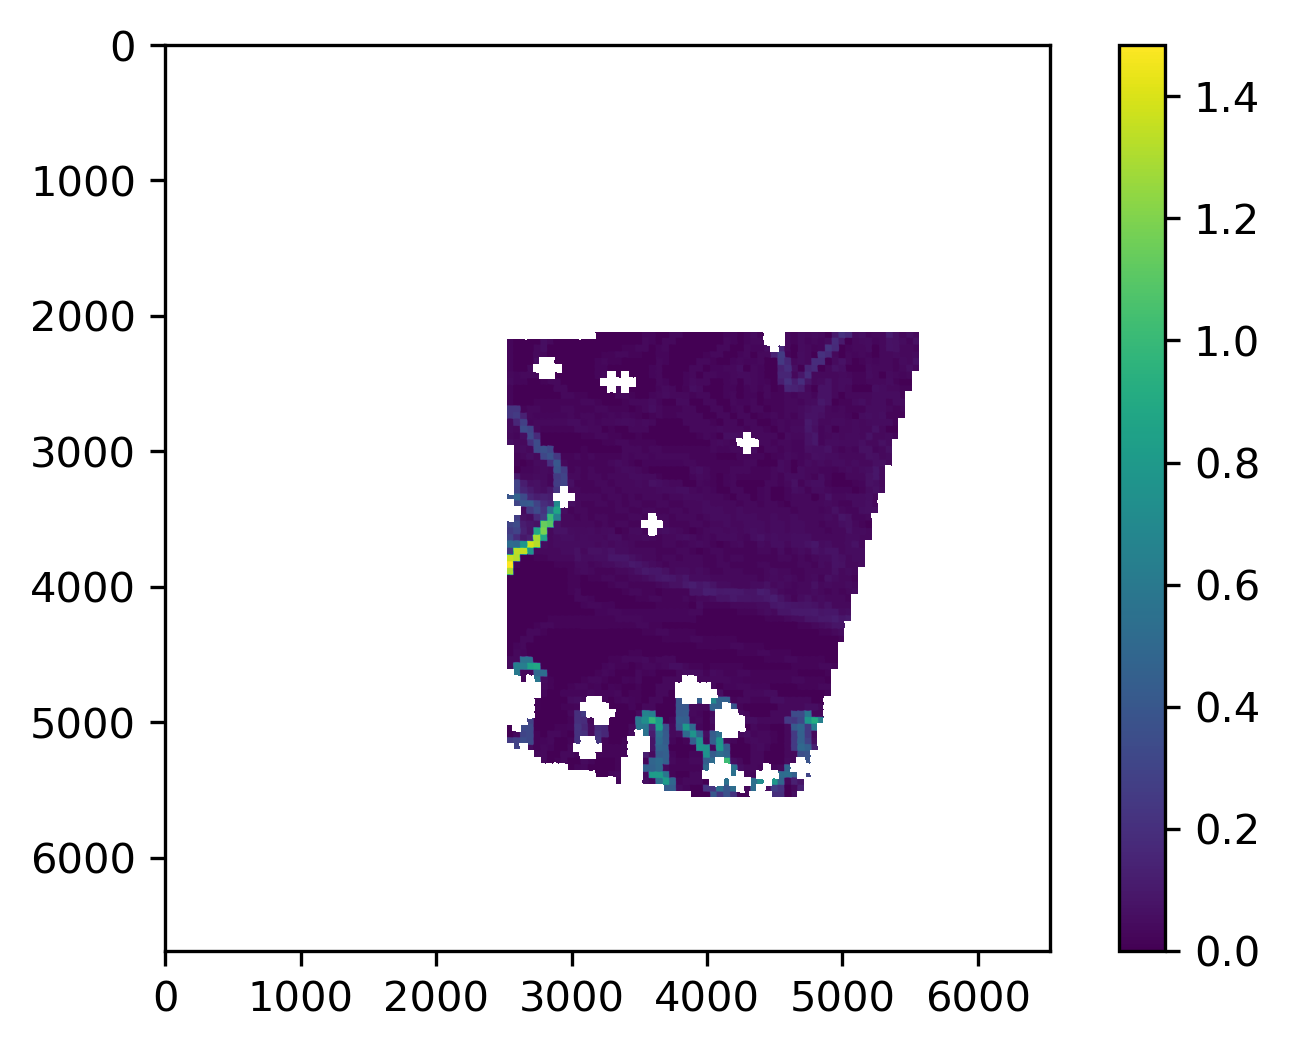

In [682]:
plt.imshow(tdef_int)
plt.colorbar()

In [13]:
tdef_int = tdef_int * 10


In [14]:
rr1, rr2, cc1, cc2  = 2000, 4500, 2000, 5500
plt.imshow(m_smmi[rr1:rr2,cc1:cc2])

NameError: name 'm_smmi' is not defined

NameError: name 'rr1' is not defined

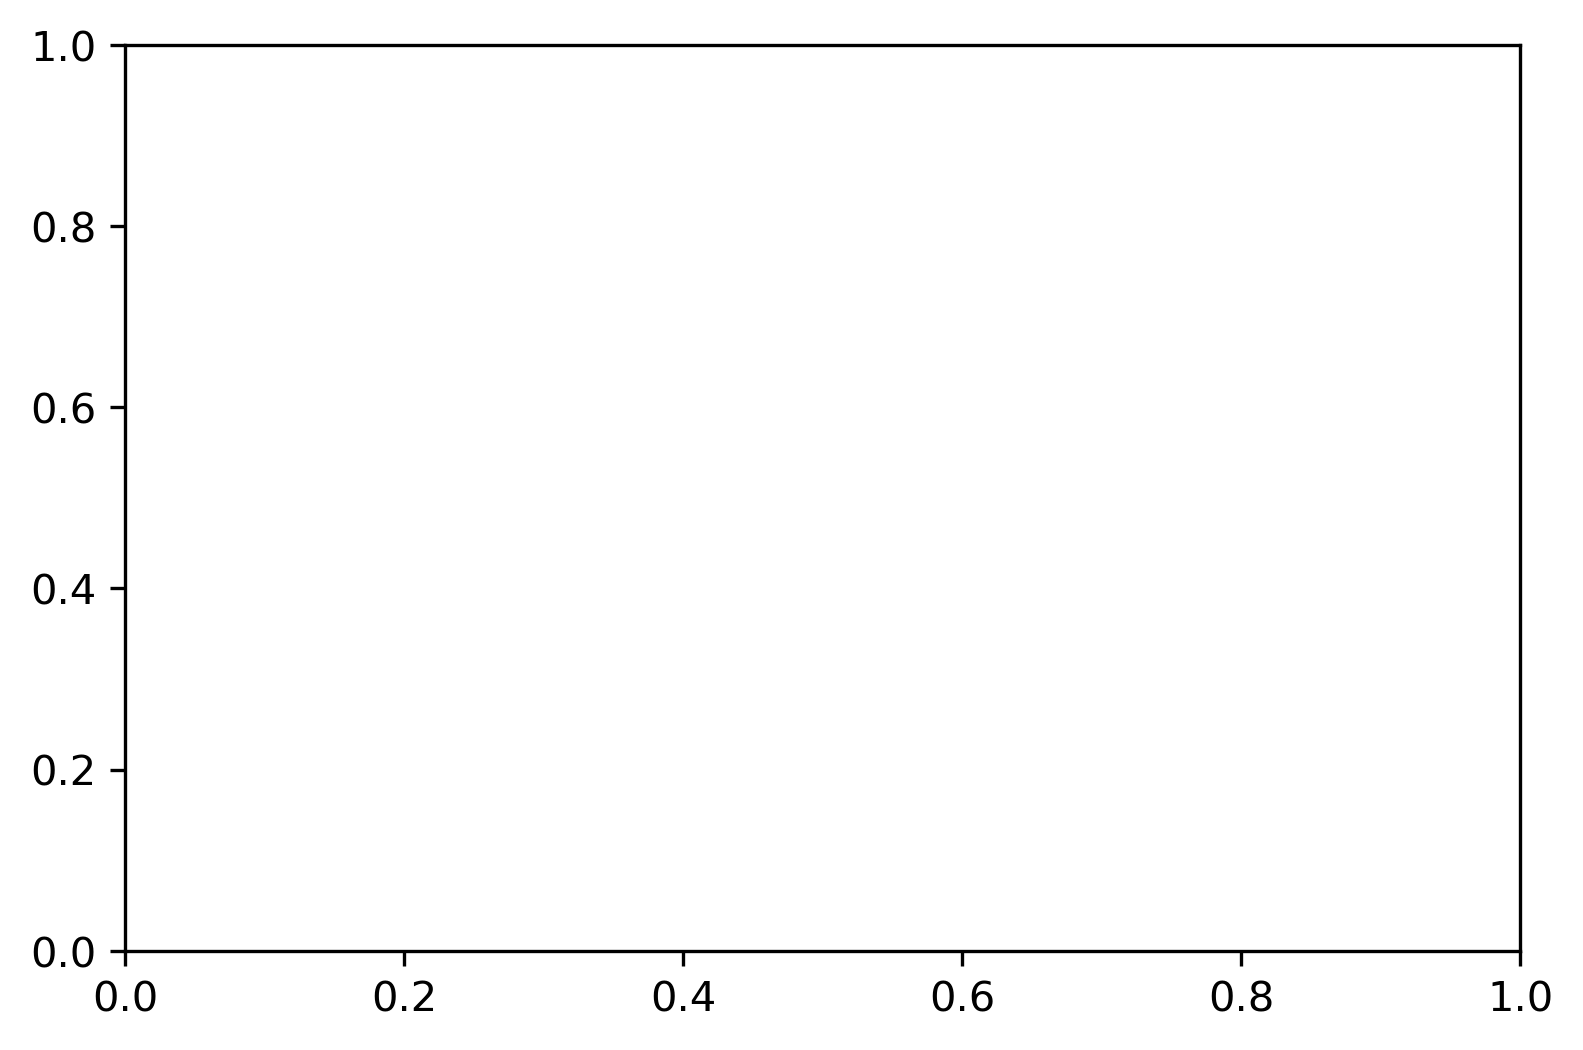

In [11]:
#############################################
# Regression between divergence and SSIM
#############################################

import statsmodels.api as sm
from statsmodels.formula.api import ols

#model = LinearRegression()

f, ax = plt.subplots(1,1)

t_def_plot = tdef_int.copy()
t_def_plot[t_def_plot<0.0008] = np.nan

'''
idx = np.argwhere(~np.isnan(t_def_plot[rr1:rr2,cc1:cc2].ravel()))
idx = idx.ravel()

t_def_plot = t_def_plot[rr1:rr2,cc1:cc2].ravel()[idx]
ssim_plot = m_smmi[rr1:rr2,cc1:cc2].ravel()[idx]

'''



#tmp_shear[tmp_shear<0.006] = np.nan
ax.scatter(np.log(tdef_int[rr1:rr2,cc1:cc2]), m_smmi[rr1:rr2,cc1:cc2], s=0.001)
plt.xlim(-5, -1)
#plt.xscale("log")

m = np.poly1d(np.log(tdef_int[rr1:rr2,cc1:cc2]).flatten().data, m_smmi[rr1:rr2,cc1:cc2].flatten(), 1)

'''
m = LinearRegression().fit(t_def_plot.reshape(-1,1), ssim_plot.reshape(-1,1))
r2 = m.score(t_def_plot.reshape(-1,1), ssim_plot.reshape(-1,1))

#m = np.poly1d(np.polyfit(t_def_plot, ssim_plot, 1))

myline = np.linspace(0.0, np.nanmax(t_def_plot), 100)
y_pred = m.intercept_ + m.coef_ * np.linspace(0.0, np.nanmax(t_def_plot), 100)

ax.set_xlabel(r'Total ice deformation rate $1/h$')
ax.set_ylabel(r'SSIM aligment quality index')

ax.plot(myline, y_pred[0], c='r')

c = np.corrcoef(t_def_plot, ssim_plot)

# Correlation
anchored_text_corr = AnchoredText("$R_2$: {:2.2f}\n$R$: {:2.2f}".format(r2, c[0,1]), loc=1)
ax.add_artist(anchored_text_corr)

# Regression coefficients
t = r"SSIM = {:.3f} {:.3f} $\times$ Total ice deformation".format(m.intercept_[0], m.coef_[0][0])
#ax.text(myline[-1] - myline[-1]/1.5, m(myline)[-1] , t, c='r')

Afont = {'family': 'serif',     
        'color':  'red',
        'weight': 'normal',
        'size': 10,
        }

anchored_text_reg = AnchoredText(t, loc=4, prop=Afont)
ax.add_artist(anchored_text_reg)

out_path = '/home/denis/L_C_alignment/report/figures/regression_ssim_tdef_ex_ng_11_2019.png'

plt.savefig(out_path, bbox_inches='tight')
'''

array([nan, nan, nan, ..., nan, nan, nan])

In [797]:
# Plot data with Pandas

import pandas as pd

# Read SSIM and defromation data into Pandas structure
my_array = np.concatenate((m_smmi[rr1:rr2,cc1:cc2].ravel().reshape(-1,1), tdef_int[rr1:rr2,cc1:cc2].ravel().reshape(-1,1)),
         axis = 1)

df = pd.DataFrame(my_array, columns = ['SSIM','T_def']).dropna()

/home/denis/.conda/envs/test2/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


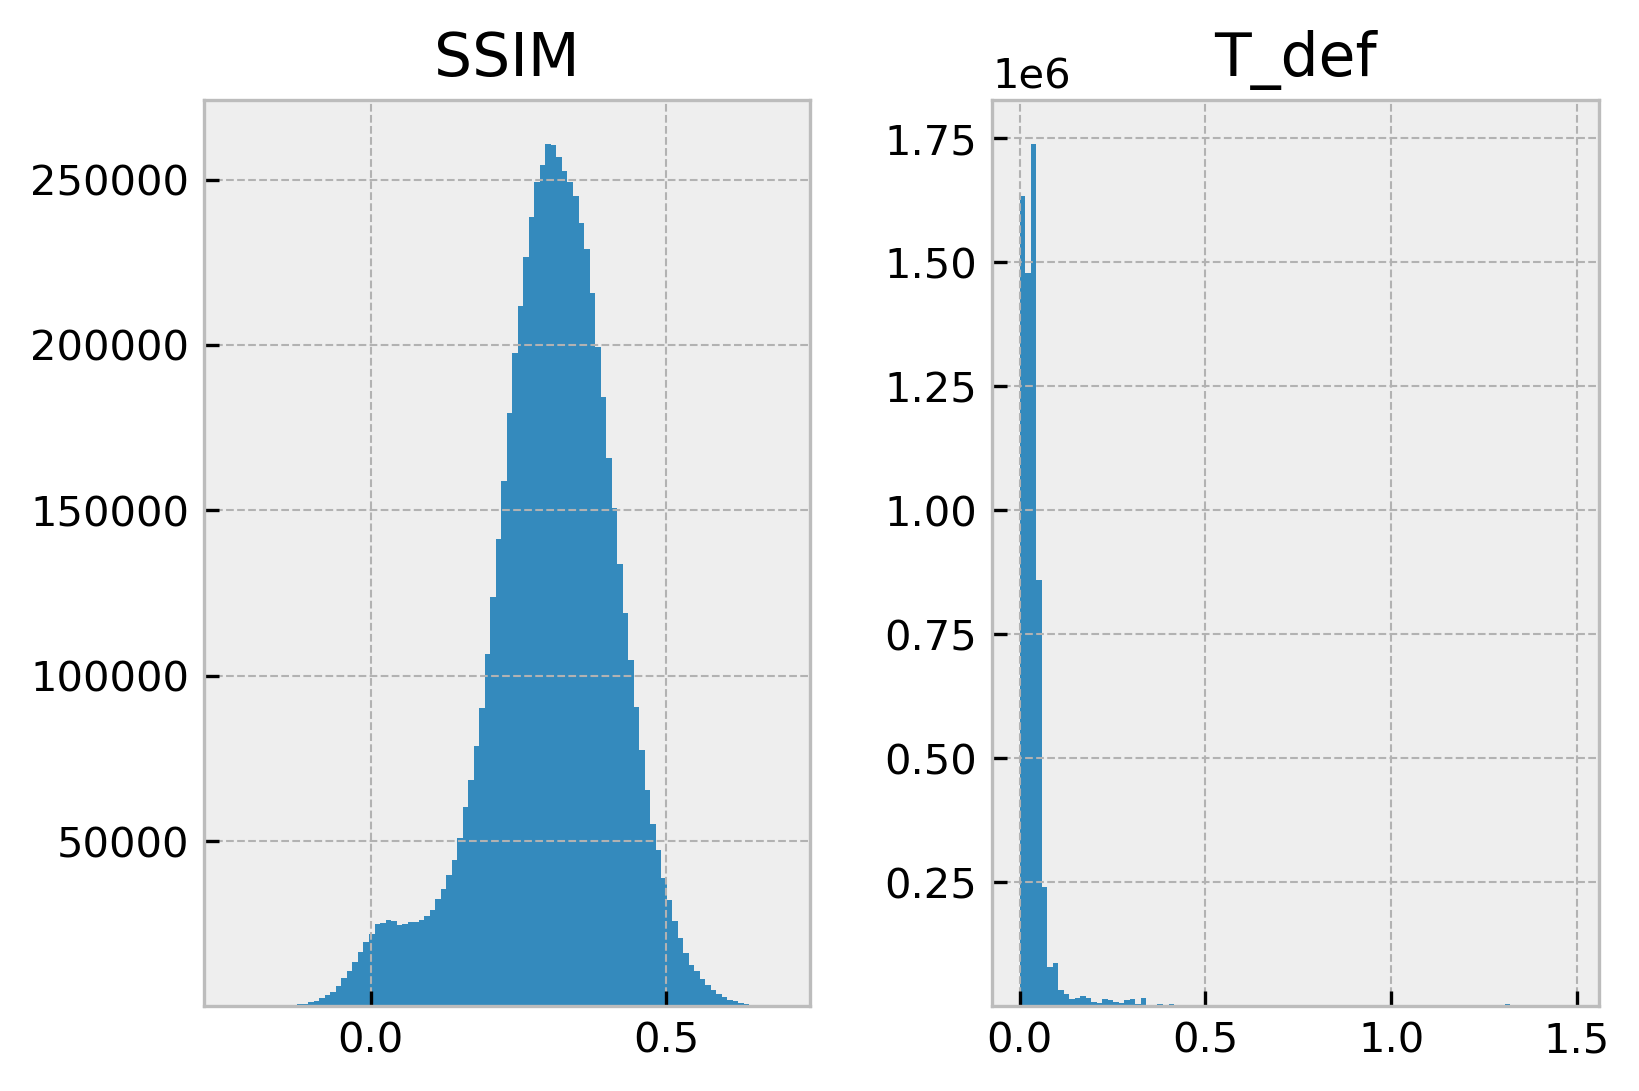

In [773]:
# Set up the scatter plot
plt.style.use('bmh')

fig, ax = plt.subplots()

df.hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')

# Add in labels for the axes
#plt.xlabel('Structure similarity mesaure (SSIM)', fontsize=14)
#plt.ylabel('Ice deformation - 1h/', fontsize=14)

Text(0, 0.5, 'Number')

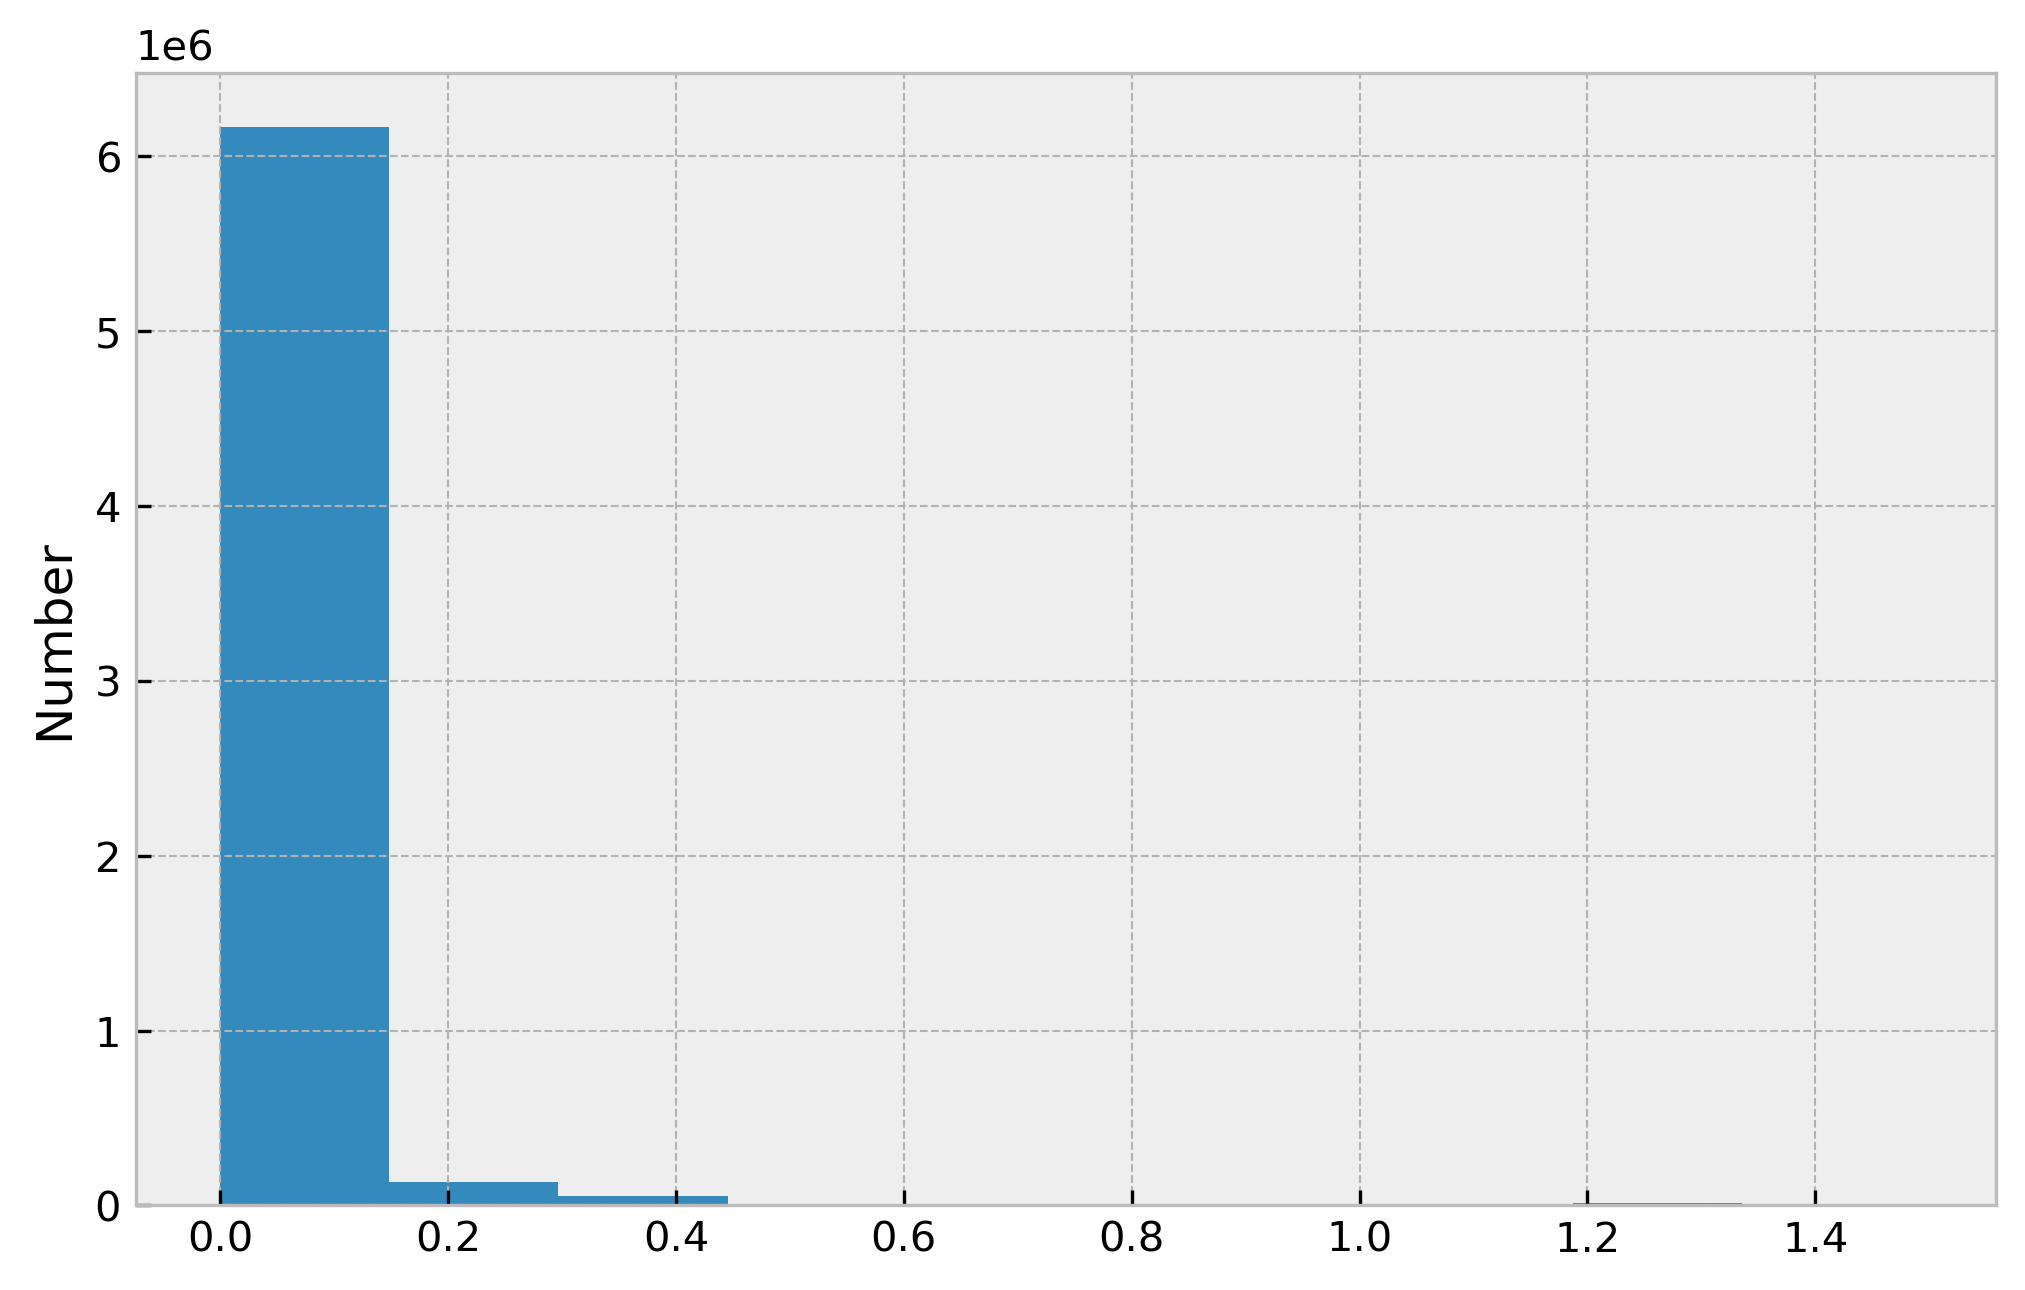

In [800]:
df.hist('T_def',figsize=(8,5))
plt.title('')
plt.ylabel('Number')

Text(0.5, 0, 'log(Total deformation)')

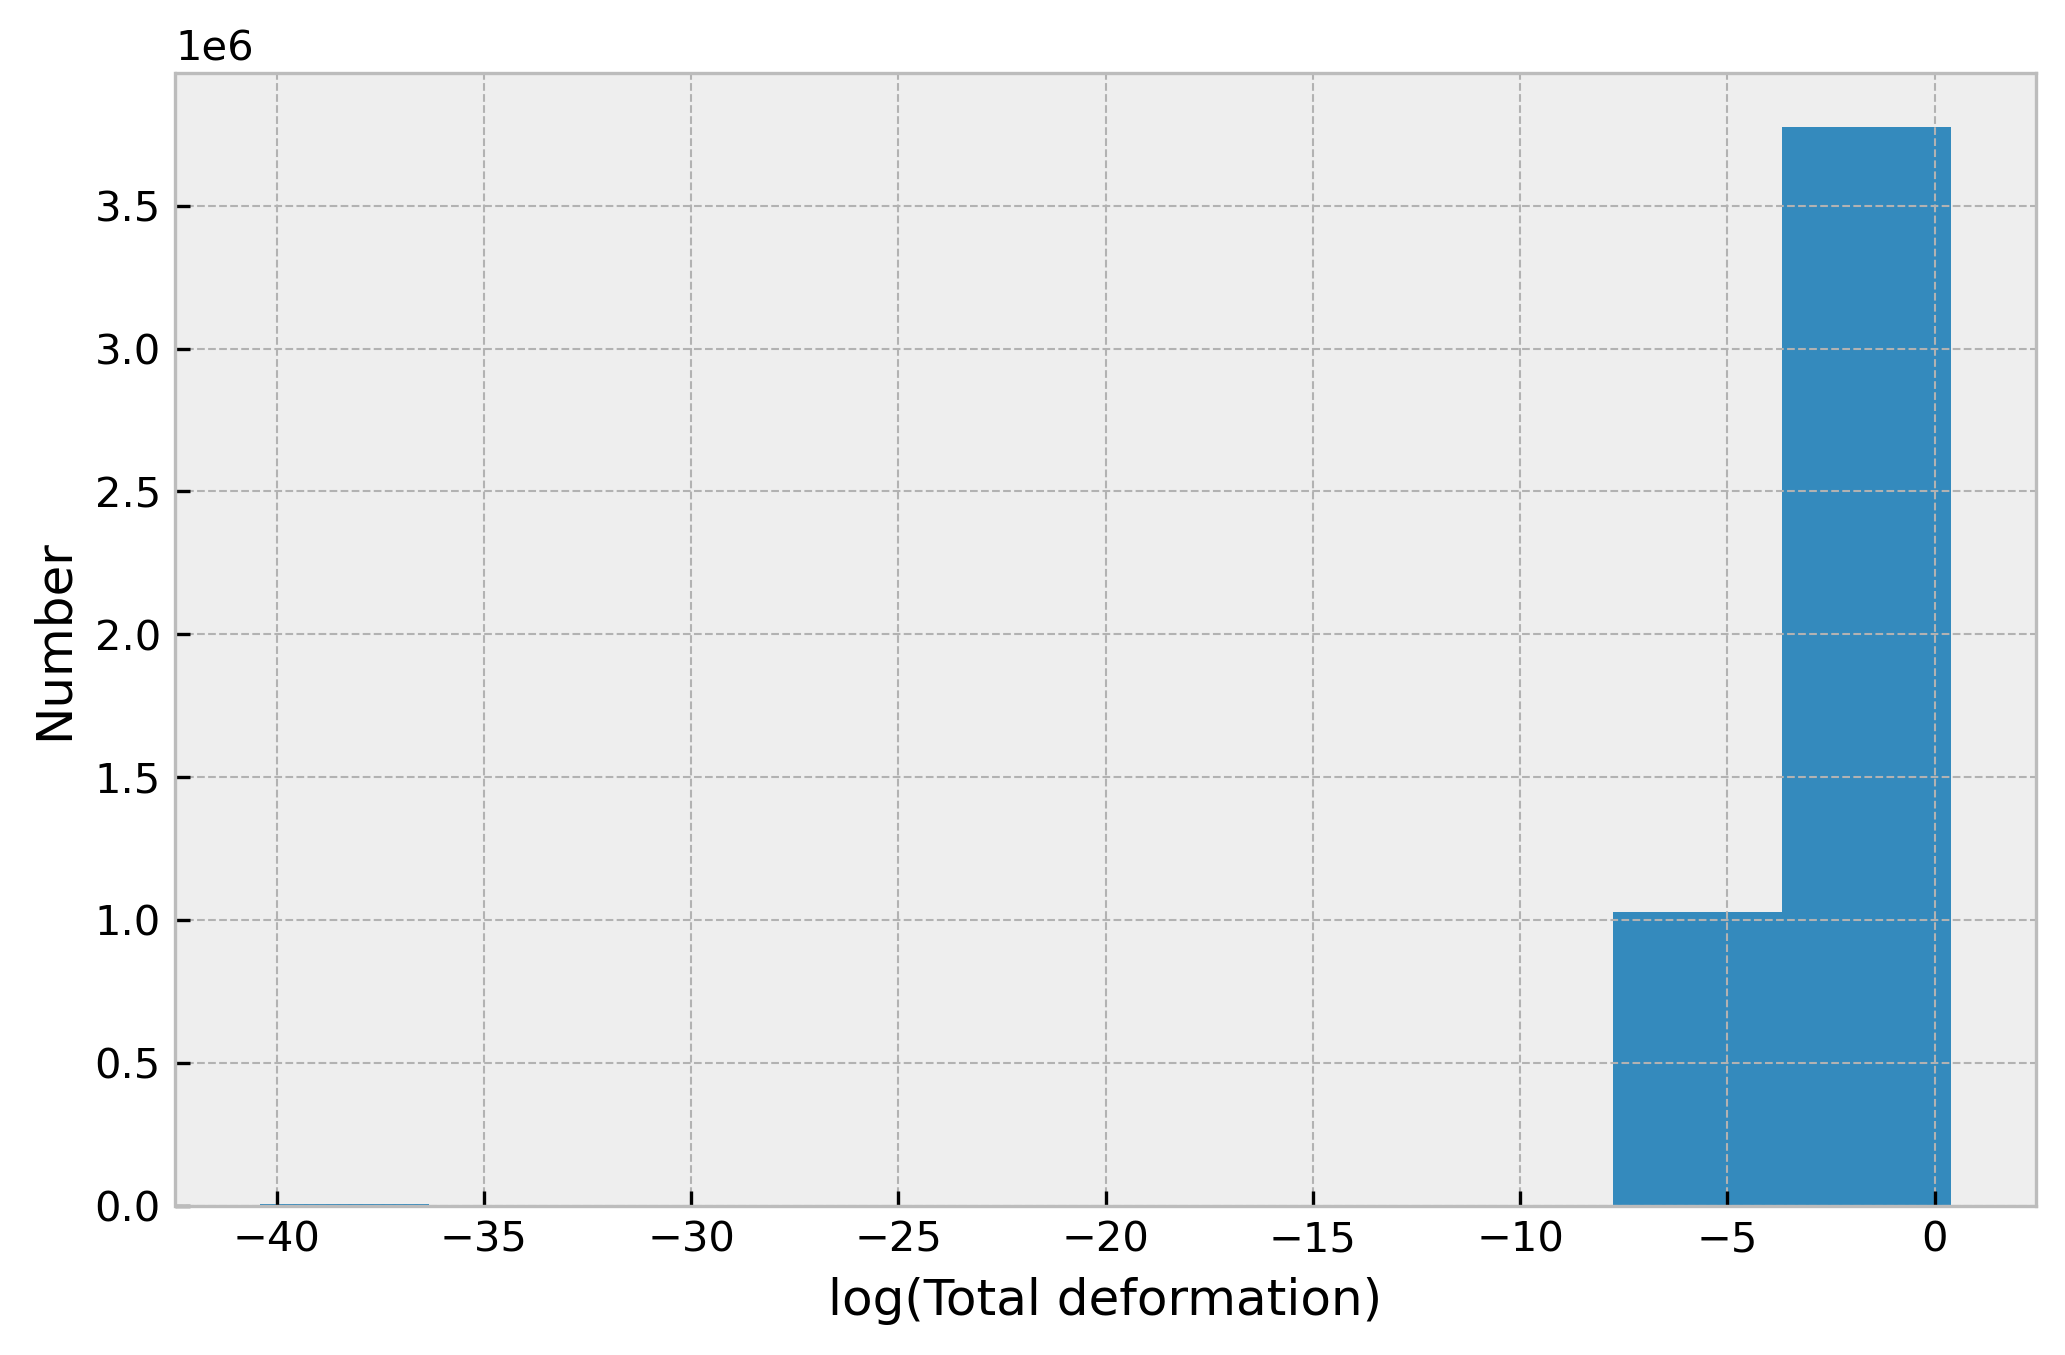

In [803]:
df['log_t_def'] = np.log(df['T_def'])
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()
df.hist('log_t_def',figsize=(8,5))
plt.title('')
plt.ylabel('Number')
plt.xlabel("log(Total deformation)")

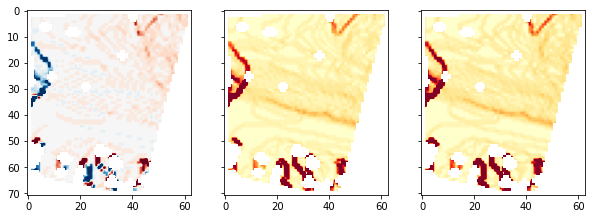

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(div, cmap='RdBu', vmin=-0.002, vmax=0.002)
ax[1].imshow(shear, cmap='YlOrRd', vmin=0., vmax=0.003)
ax[2].imshow(t_def,  cmap='YlOrRd', vmin=0., vmax=0.003)


In [6]:
cd /home/denis/git/MOIRA/

/home/denis/git/MOIRA


In [7]:
from ridge_classification import *

In [8]:
# Reproject defo file
reader = dataReader()

f_div = '/data/rrs/seaice/esa_rosel/L_C_pairs/north_greenland/wb_dd/drift_results/019/output/DIV_20191125T1740_20191127T1903.tiff'
f_shear = '/data/rrs/seaice/esa_rosel/L_C_pairs/north_greenland/wb_dd/drift_results/019/output/SHEAR_20191125T1740_20191127T1903.tiff'

# Interpolate divergence
r = Resampler(f_div, f1)
div_int = r.resample(r.f_source['lons'], r.f_source['lats'],
                       r.f_target['lons'], r.f_target['lats'], r.f_source['data']['s0'], method='nearest')

# Interpolate shear
r = Resampler(f_shear, f1)
shear_int = r.resample(r.f_source['lons'], r.f_source['lats'],
                       r.f_target['lons'], r.f_target['lats'], r.f_source['data']['s0'], method='nearest')


Resampling source file: /data/rrs/seaice/esa_rosel/L_C_pairs/north_greenland/wb_dd/drift_results/019/output/DIV_20191125T1740_20191127T1903.tiff ...
Done.


Resampling target file: /home/denis/L_C_alignment/aligned/north_greenland/019/UPS_XX_S1B_EW_GRDM_1SDH_20191127T190340_20191127T190444_019117_02414A_A64B.tiff ...
Done.


Resampling source file: /data/rrs/seaice/esa_rosel/L_C_pairs/north_greenland/wb_dd/drift_results/019/output/SHEAR_20191125T1740_20191127T1903.tiff ...
Done.


Resampling target file: /home/denis/L_C_alignment/aligned/north_greenland/019/UPS_XX_S1B_EW_GRDM_1SDH_20191127T190340_20191127T190444_019117_02414A_A64B.tiff ...
Done.



In [318]:
cd /home/denis/git/MOIRA/

/home/denis/git/MOIRA


In [607]:
#################################
# Pair statistics
#################################

from ridge_classification import *
import os
import re
from datetime import datetime


def get_f_dt(filename):
    dt_str = re.findall(r'\d+T\d+', filename)[0]
    date_time_str = '%s-%s-%s %s:%s:%s' % (dt_str[0:4], dt_str[4:6], dt_str[6:8],
                                    dt_str[9:11], dt_str[11:13], dt_str[13:15])
    
    return datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')
    
def get_overlap_area(filename):
    ''' Get area of not NaN pixels in km2 '''
    
    ds = gdal.Open(filename)
    data = ds.ReadAsArray()[0]
    dx = ds.GetGeoTransform()[1] * 0.001
    dy = ds.GetGeoTransform()[-1] * 0.001 * (-1)
    del ds
    return len(data[~np.isnan(data)])*dx*dy

def get_stable_fraction(filename, th):
    ''' Get fraction of stable area based in  '''
    
    ds = gdal.Open(filename)
    data = ds.ReadAsArray()
    dx = ds.GetGeoTransform()[1] * 0.001
    dy = ds.GetGeoTransform()[-1] * 0.001 * (-1)
    del ds
    
    a_def = len( data[~np.isnan(data)] ) * dx * dy
    
    if a_def > 0:
        a_def_stable = (len(data[~np.isnan(data)][data[~np.isnan(data)] < th])  * dx * dy) / a_def
        return a_def, a_def_stable
    else:
        return np.nan, np.nan
    
def get_mean_speed(filename):
    ''' Get mean drift displacement '''
    nc = Dataset(filename)
    data = np.nanmean(nc['Ice_speed_magnitude'][:]) 
    nc.close()
    
    return data
    
# Constants

# Total deformation value for stable zones
t_def_th = 0.004

res_d = {}
res_new = {}

test_sites = ['north_greenland', 'belgica', 'fram']

for test_site in test_sites:
    res_d[test_site] = {}
    
    print(f'test site: {test_site}')
    
    base_dir = f'/data/rrs/seaice/esa_rosel/L_C_pairs/{test_site}'
    
    ddirs = [x[0] for x in os.walk(base_dir)]
    
    for idir in ddirs:
        if idir.endswith('_dd'):
            print(idir)
            path_dir = f'{idir}/alignments'
            
            for path, directories, files in os.walk(path_dir):
                for file in files:
                    if file.endswith('tiff'):
                        
                        if 'ALOS2' in file:
                            print(path)
                            pair_num = path.split('/')[-1]

                            if not pair_num in res_d[test_site]:
                                res_d[test_site][pair_num] = {}

                                res_d[test_site][pair_num]['ALOS2_file'] = {}
                                res_d[test_site][pair_num]['ALOS2_file']['name'] = file
                                res_d[test_site][pair_num]['ALOS2_file']['mode'] = path_dir.split('/')[-2][0:2]
                            else:
                                res_d[test_site][pair_num]['ALOS2_file'] = {}
                                res_d[test_site][pair_num]['ALOS2_file']['name'] = file
                                res_d[test_site][pair_num]['ALOS2_file']['mode'] = path_dir.split('/')[-2][0:2]

                            fpath = os.path.join(path, file)
                            dt = get_f_dt(file)

                            img_mode = path_dir.split('/')[-2][0]

                            if img_mode == 'w':
                                mode = 'WB'
                            else:
                                mode = ''

                            # Get overlaped area
                            try:
                                a = get_overlap_area(fpath)
                                res_d[test_site][pair_num]['overlap_area'] = f'{a:.2f}'
                            except:
                                print('Warning: Could not calculate area')

                            # Get stable fraction
                            f_defo_path = path.replace('alignments', 'drift_results') + '/output'
                            f_defo_temp = glob.glob(f"{f_defo_path}/*TOTAL*{file.split('_')[7][:-2]}*.tiff")

                            if os.path.exists(f_defo_temp[0]):
                                a_def, a_def_stable = get_stable_fraction(f_defo_temp[0], t_def_th)
                            else:
                                a_def, a_def_stable = None, None

                            res_d[test_site][pair_num]['defo_area'] = a_def
                            res_d[test_site][pair_num]['defo_stable_frac'] = a_def_stable

                            # Get mean drift magnitude (displacement)        
                            f_nc_path = path.replace('alignments', 'drift_results') + '/output'
                            f_nc_temp = glob.glob(f"{f_defo_path}/*Ice_Defo*{file.split('_')[7][:-2]}*.nc")

                            if os.path.exists(f_nc_temp[0]):
                                print(f_nc_temp[0])
                                s_mean = get_mean_speed(f_nc_temp[0])
                            else:
                                s_mean = None

                            res_d[test_site][pair_num]['mean_ice_speed'] = s_mean

                            print(f'ALOS2: {dt.year:4d} {dt.month:02d} {dt.day:02} {dt.hour:02d} {dt.minute:02d} {dt.second:02d} {mode} {a:.2f} {a_def:.1f} {a_def_stable:.3f} {s_mean:.3f}') 

                            res_d[test_site][pair_num]['ALOS2_file']['datetime'] = dt
                            res_d[test_site][pair_num]['datetime'] = dt

                        if 'S1' in file:
                            pair_num = path.split('/')[-1]

                            if not pair_num in res_d[test_site]:
                                res_d[test_site][pair_num] = {}
                                res_d[test_site][pair_num]['S1_file'] = {}
                                res_d[test_site][pair_num]['S1_file']['name'] = file
                                
                                if path_dir.split('/')[-2][0:2][0] == 'w':
                                    res_d[test_site][pair_num]['S1_file']['mode'] = 'EW'
                                if path_dir.split('/')[-2][0:2][0] == 'f':
                                    res_d[test_site][pair_num]['S1_file']['mode'] = 'EW'
                            else:
                                res_d[test_site][pair_num]['S1_file'] = {}
                                res_d[test_site][pair_num]['S1_file']['name'] = file
                                if path_dir.split('/')[-2][0:2][0] == 'w':
                                    res_d[test_site][pair_num]['S1_file']['mode'] = 'EW'
                                if path_dir.split('/')[-2][0:2][0] == 'f':
                                    res_d[test_site][pair_num]['S1_file']['mode'] = 'EW'

                            fpath = os.path.join(path, file)
                            dt = get_f_dt(file)

                            img_mode = path_dir.split('/')[-2][0]

                            if img_mode == 'w':
                                mode = 'EW'
                            else:
                                mode = ''

                            print(f'S1: {dt.year:4d} {dt.month:02d} {dt.day:02} {dt.hour:02d} {dt.minute:02d} {dt.second:02d} {mode}')

                            res_d[test_site][pair_num]['S1_file']['datetime'] = dt

            # Sort results dictonary
            res_new[test_site] = dict(sorted(res_d[test_site].items(), key=lambda x: x[1]['datetime'], reverse=True))


test site: north_greenland
/data/rrs/seaice/esa_rosel/L_C_pairs/north_greenland/wb_dd
S1: 2019 07 10 11 58 05 EW
/data/rrs/seaice/esa_rosel/L_C_pairs/north_greenland/wb_dd/alignments/110
/data/rrs/seaice/esa_rosel/L_C_pairs/north_greenland/wb_dd/drift_results/110/output/Chalmers_Ice_Defo_20190708T1740_20190710T1158.nc
ALOS2: 2019 07 08 17 40 21 WB 73308.89 64577.7 0.932 1.018
/data/rrs/seaice/esa_rosel/L_C_pairs/north_greenland/wb_dd/alignments/081


/home/denis/.conda/envs/test2/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


/data/rrs/seaice/esa_rosel/L_C_pairs/north_greenland/wb_dd/drift_results/081/output/Chalmers_Ice_Defo_20190902T1740_20190902T1741.nc
ALOS2: 2019 09 02 17 40 21 WB 101641.47 91359.2 0.527 413.487
S1: 2019 09 02 17 41 36 EW
/data/rrs/seaice/esa_rosel/L_C_pairs/north_greenland/wb_dd/alignments/132
/data/rrs/seaice/esa_rosel/L_C_pairs/north_greenland/wb_dd/drift_results/132/output/Chalmers_Ice_Defo_20190626T1822_20190627T1256.nc
ALOS2: 2019 06 26 18 22 05 WB 61916.19 46802.1 0.726 5.658
S1: 2019 06 27 12 56 26 EW
S1: 2019 07 09 09 38 29 EW
/data/rrs/seaice/esa_rosel/L_C_pairs/north_greenland/wb_dd/alignments/118
/data/rrs/seaice/esa_rosel/L_C_pairs/north_greenland/wb_dd/drift_results/118/output/Chalmers_Ice_Defo_20190708T1740_20190709T0938.nc
ALOS2: 2019 07 08 17 40 21 WB 1621.88 750.1 0.767 1.069
S1: 2019 04 29 18 31 17 EW
/data/rrs/seaice/esa_rosel/L_C_pairs/north_greenland/wb_dd/alignments/008
/data/rrs/seaice/esa_rosel/L_C_pairs/north_greenland/wb_dd/drift_results/008/output/Chalmers_I

/data/rrs/seaice/esa_rosel/L_C_pairs/north_greenland/wb_dd/drift_results/046/output/Chalmers_Ice_Defo_20191028T1740_20191030T1303.nc
ALOS2: 2019 10 28 17 40 22 WB 69945.10 58566.9 0.956 1.863
S1: 2019 10 30 13 03 35 EW
/data/rrs/seaice/esa_rosel/L_C_pairs/north_greenland/wb_dd/alignments/060
/data/rrs/seaice/esa_rosel/L_C_pairs/north_greenland/wb_dd/drift_results/060/output/Chalmers_Ice_Defo_20191028T1740_20191028T1814.nc
ALOS2: 2019 10 28 17 40 22 WB 115115.30 94768.1 0.664 13.821
S1: 2019 10 28 18 14 35 EW
S1: 2019 11 27 17 25 14 EW
/data/rrs/seaice/esa_rosel/L_C_pairs/north_greenland/wb_dd/alignments/021
/data/rrs/seaice/esa_rosel/L_C_pairs/north_greenland/wb_dd/drift_results/021/output/Chalmers_Ice_Defo_20191125T1740_20191127T1725.nc
ALOS2: 2019 11 25 17 40 23 WB 90823.15 80928.3 0.978 0.395
S1: 2019 07 08 18 47 14 EW
/data/rrs/seaice/esa_rosel/L_C_pairs/north_greenland/wb_dd/alignments/119
/data/rrs/seaice/esa_rosel/L_C_pairs/north_greenland/wb_dd/drift_results/119/output/Chalmers

/data/rrs/seaice/esa_rosel/L_C_pairs/belgica/fbd_dd/drift_results/034/output/Chalmers_Ice_Defo_20190831T1345_20190901T0801.nc
ALOS2: 2019 08 31 13 45 11  94803.49 5299.7 0.514 5.535
S1: 2019 09 01 16 59 07 
/data/rrs/seaice/esa_rosel/L_C_pairs/belgica/fbd_dd/alignments/029
/data/rrs/seaice/esa_rosel/L_C_pairs/belgica/fbd_dd/drift_results/029/output/Chalmers_Ice_Defo_20190831T1345_20190901T1659.nc
ALOS2: 2019 08 31 13 45 11  74292.42 1475.0 0.373 4.894
/data/rrs/seaice/esa_rosel/L_C_pairs/belgica/fbd_dd/alignments/005
/data/rrs/seaice/esa_rosel/L_C_pairs/belgica/fbd_dd/drift_results/005/output/Chalmers_Ice_Defo_20200104T1345_20200104T1707.nc
ALOS2: 2020 01 04 13 45 14  75309.72 58705.9 0.444 12.248
S1: 2020 01 04 17 07 18 
/data/rrs/seaice/esa_rosel/L_C_pairs/belgica/fbd_dd/alignments/038
/data/rrs/seaice/esa_rosel/L_C_pairs/belgica/fbd_dd/drift_results/038/output/Chalmers_Ice_Defo_20190803T1345_20190804T0744.nc
ALOS2: 2019 08 03 13 45 10  77738.24 9098.8 0.255 6.432
S1: 2019 08 04 07 4

/data/rrs/seaice/esa_rosel/L_C_pairs/fram/wb_dd/drift_results/010/output/Chalmers_Ice_Defo_20191210T1446_20191210T1627.nc
ALOS2: 2019 12 10 14 46 29 WB 22575.33 19473.5 0.077 18.828
S1: 2019 05 29 09 29 45 EW
/data/rrs/seaice/esa_rosel/L_C_pairs/fram/wb_dd/alignments/031
/data/rrs/seaice/esa_rosel/L_C_pairs/fram/wb_dd/drift_results/031/output/Chalmers_Ice_Defo_20190529T0929_20190529T1507.nc
ALOS2: 2019 05 29 15 07 18 WB 61696.63 57950.0 0.964 4.839
/data/rrs/seaice/esa_rosel/L_C_pairs/fram/wb_dd/alignments/015
/data/rrs/seaice/esa_rosel/L_C_pairs/fram/wb_dd/drift_results/015/output/Chalmers_Ice_Defo_20190602T1352_20190602T1453.nc
ALOS2: 2019 06 02 14 53 23 WB 10345.73 8548.8 0.722 7.916
S1: 2019 06 02 13 52 28 EW
/data/rrs/seaice/esa_rosel/L_C_pairs/fram/wb_dd/alignments/046
/data/rrs/seaice/esa_rosel/L_C_pairs/fram/wb_dd/drift_results/046/output/Chalmers_Ice_Defo_20190501T0824_20190501T1507.nc
ALOS2: 2019 05 01 15 07 18 WB 55502.12 52126.5 0.762 15.430
S1: 2019 05 01 08 24 24 EW
S1: 2

/data/rrs/seaice/esa_rosel/L_C_pairs/fram/fbd_dd/drift_results/021/output/Chalmers_Ice_Defo_20190902T0929_20190902T1426.nc
ALOS2: 2019 09 02 14 26 04  3746.48 2850.9 0.930 8.001
S1: 2019 09 02 09 29 51 
/data/rrs/seaice/esa_rosel/L_C_pairs/fram/fbd_dd/alignments/012
/data/rrs/seaice/esa_rosel/L_C_pairs/fram/fbd_dd/drift_results/012/output/Chalmers_Ice_Defo_20190930T0858_20190930T1426.nc
ALOS2: 2019 09 30 14 26 12  3854.30 3022.5 0.950 9.395
S1: 2019 09 30 08 58 03 
/data/rrs/seaice/esa_rosel/L_C_pairs/fram/fbd_dd/alignments/001
/data/rrs/seaice/esa_rosel/L_C_pairs/fram/fbd_dd/drift_results/001/output/Chalmers_Ice_Defo_20191209T0735_20191209T1426.nc
ALOS2: 2019 12 09 14 26 14  2956.63 2225.5 0.528 17.453
S1: 2019 12 09 07 35 32 
S1: 2019 09 02 07 51 51 
/data/rrs/seaice/esa_rosel/L_C_pairs/fram/fbd_dd/alignments/020
/data/rrs/seaice/esa_rosel/L_C_pairs/fram/fbd_dd/drift_results/020/output/Chalmers_Ice_Defo_20190902T0751_20190902T1426.nc
ALOS2: 2019 09 02 14 26 12  3609.74 2701.3 0.556 7

In [570]:
# (pair_id, alos_dt, t_dif, alos_mode, area_overlap, area_def, area_stable, ice_speed)
#irow = '''\multirow{2}{*}{%s} & \multirow{1}{*}{ALOS-2} & %s & \multirow{2}{*}{%s} && \multirow{2}{*}{%s} & \multirow{2}{*}{%s}  & \multirow{2}{*}{%s} & \multirow{2}{*}{%s} \\ \cline{2-3} & \multirow{1}{*}{S1} & %s && EW &&&& \\ \hline''' % (pair_id, alos_dt, t_dif, alos_mode, area_overlap, area_def, area_stable, ice_speed, s1_dt)

In [608]:
res_new['belgica'].keys()

dict_keys(['018', '004', '016', '005', '023', '007', '001', '003', '028', '009', '034', '029', '038', '041', '043', '011', '049', '012', '056', '060', '061', '057', '058', '053', '059', '064', '070', '014', '068'])

In [609]:
########################################
# Make Latex longtable
# from processed pairs
########################################

pair_id = 1

# pair_id, alos_dt, t_dif, alos_mode, area_overlap, area_def, area_stable, ice_speed, s1_dt

istr = ''

for test_site in res_new.keys():
    istr = ''
    for item in res_new[test_site]:
        #print(res_new[test_site][item])
        
        if 'ALOS2_file' in res_new[test_site][item].keys() and 'S1_file' in res_new[test_site][item].keys():
            
            #print(pair_id)
            
            alos_dt = res_new[test_site][item]['ALOS2_file']['datetime']
            alos_dt_str = f'{alos_dt.year:4d}-{alos_dt.month:02d}-{alos_dt.day:02d} {alos_dt.hour:02d}:{alos_dt.minute:02d}:{alos_dt.second:02d}'
            #print(alos_dt_str)

            s1_dt = res_new[test_site][item]['S1_file']['datetime']
            s1_dt_str = f'{s1_dt.year:4d}-{s1_dt.month:02d}-{s1_dt.day:02d} {s1_dt.hour:02d}:{s1_dt.minute:02d}:{s1_dt.second:02d}'
            #print(s1_dt_str)
            
            t_diff = abs((s1_dt - alos_dt).total_seconds() / 3600.)
            t_dif = f'{t_diff:.1f}'
            #print(t_dif)
            
            
            area_overlap = '{:.1f}'.format(float(res_new[test_site][item]['overlap_area']))
            area_def = '{:.1f}'.format(float(res_new[test_site][item]['defo_area']))
            frac_stable = '{:.1f}'.format(float(res_new[test_site][item]['defo_stable_frac']))
            ice_speed = '{:.1f}'.format(float(res_new[test_site][item]['mean_ice_speed']))
            
            alos2_mode = '{}'.format(res_new[test_site][item]['ALOS2_file']['mode'].upper())
            s1_mode = '{}'.format(res_new[test_site][item]['S1_file']['mode'].upper())
            
            if float(res_new[test_site][item]['mean_ice_speed'])< 100.:
                istr += r' \multirow{2}{*}{%s} & \multirow{1}{*}{ALOS-2} & %s & \multirow{2}{*}{%s} & \multirow{1}{*}{%s} & \multirow{2}{*}{%s}  & \multirow{2}{*}{%s} & \multirow{2}{*}{%s} & \multirow{2}{*}{%s} \\ \cline{2-3} & \multirow{1}{*}{S1} & %s && %s &&&& \\ \hline ' % (pair_id, alos_dt, t_dif, alos2_mode, area_overlap, area_def, frac_stable, ice_speed, s1_dt, s1_mode)
                pair_id += 1
            else:
                pass
            
            #print()
    
    # Make latex long table form dictonary with results
    llabel = test_site.replace('_',' ').upper()
    caption = f'List of processed pairs in {llabel}'
    label = f'tbl:{llabel}'
    content = istr

    st = r'\begin{longtable}{lllllllll} \caption{%s} \label{%s} \\ ID && Date/time & T_{dif} & Mode & A_{overlap} & A_{def} & F_{stable} & S_{mean} \\ \hline %s \end{longtable}' % (caption, label, content)
    
    print(st)

\begin{longtable}{lllllllll} \caption{List of processed pairs in NORTH GREENLAND} \label{tbl:NORTH GREENLAND} \\ ID && Date/time & T_{dif} & Mode & A_{overlap} & A_{def} & F_{stable} & S_{mean} \\ \hline  \multirow{2}{*}{1} & \multirow{1}{*}{ALOS-2} & 2019-12-09 17:40:24 & \multirow{2}{*}{1.4} & \multirow{1}{*}{WB} & \multirow{2}{*}{94356.0}  & \multirow{2}{*}{82042.3} & \multirow{2}{*}{0.3} & \multirow{2}{*}{12.3} \\ \cline{2-3} & \multirow{1}{*}{S1} & 2019-12-09 19:03:40 && EW &&&& \\ \hline  \multirow{2}{*}{2} & \multirow{1}{*}{ALOS-2} & 2019-12-09 17:40:24 & \multirow{2}{*}{49.1} & \multirow{1}{*}{WB} & \multirow{2}{*}{102723.6}  & \multirow{2}{*}{80787.5} & \multirow{2}{*}{0.8} & \multirow{2}{*}{4.3} \\ \cline{2-3} & \multirow{1}{*}{S1} & 2019-12-11 18:47:17 && EW &&&& \\ \hline  \multirow{2}{*}{3} & \multirow{1}{*}{ALOS-2} & 2019-12-09 17:40:24 & \multirow{2}{*}{1.4} & \multirow{1}{*}{WB} & \multirow{2}{*}{94356.0}  & \multirow{2}{*}{82042.3} & \multirow{2}{*}{0.3} & \multirow{2}

In [566]:
# Make latex long table form dictonary with results
caption = f'List of processed pairs in {test_site}'
label = f'tbl:{test_site}'
content = istr

st = r'\begin{longtable}{lllllllll} \caption{%s} \label{%s} \\ ID && Date/time & T_{dif} & Mode & A_{overlap} & A_{def} & F_{stable} & S_{mean} \\ \hline %s \end{longtable}' % (caption, label, content)

In [567]:
print(st)

\begin{longtable}{lllllllll} \caption{List of processed pairs in north_greenland} \label{tbl:north_greenland} \\ ID && Date/time & T_{dif} & Mode & A_{overlap} & A_{def} & F_{stable} & S_{mean} \\ \hline  \multirow{2}{*}{0} & \multirow{1}{*}{ALOS-2} & 2019-12-09 17:40:24 & \multirow{2}{*}{1.4} & \multirow{1}{*}{WB} & \multirow{2}{*}{94356.0}  & \multirow{2}{*}{82042.3} & \multirow{2}{*}{0.3} & \multirow{2}{*}{12.3} \\ \cline{2-3} & \multirow{1}{*}{S1} & 2019-12-09 19:03:40 && EW &&&& \\ \hline  \multirow{2}{*}{1} & \multirow{1}{*}{ALOS-2} & 2019-12-09 17:40:24 & \multirow{2}{*}{49.1} & \multirow{1}{*}{WB} & \multirow{2}{*}{102723.6}  & \multirow{2}{*}{80787.5} & \multirow{2}{*}{0.8} & \multirow{2}{*}{4.3} \\ \cline{2-3} & \multirow{1}{*}{S1} & 2019-12-11 18:47:17 && EW &&&& \\ \hline  \multirow{2}{*}{2} & \multirow{1}{*}{ALOS-2} & 2019-12-09 17:40:24 & \multirow{2}{*}{1.4} & \multirow{1}{*}{WB} & \multirow{2}{*}{94356.0}  & \multirow{2}{*}{82042.3} & \multirow{2}{*}{0.3} & \multirow{2}

In [568]:
res_d['north_greenland']['110']


{'S1_file': {'name': 'Aligned_UPS_XX_S1B_EW_GRDM_1SDH_20190710T115805_20190710T115905_017071_0201E7_409F.tiff',
  'datetime': datetime.datetime(2019, 7, 10, 11, 58, 5)},
 'ALOS2_file': {'name': 'Aligned_UPS_XX_ALOS2_XX_XXXX_XXXX_20190708T174021_20190708T174113_0000326095_001001_ALOS2276731900-190708.tiff',
  'datetime': datetime.datetime(2019, 7, 8, 17, 40, 21)},
 'overlap_area': '73308.89',
 'defo_area': 64577.683745496855,
 'defo_stable_frac': 0.9322493224932249,
 'mean_ice_speed': 1.0183029,
 'datetime': datetime.datetime(2019, 7, 8, 17, 40, 21)}